# Segmenter for Semantic Segmentation on OxfordIIITPet using ViT-Small

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
import timm
import numpy as np
import os


# Config

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_CLASSES = 3
EPOCHS = 20

# Dataset

In [3]:
# Transformations
transform = transforms.Compose([
transforms.Resize((IMG_SIZE, IMG_SIZE)),
transforms.ToTensor(),
])


target_transform = transforms.Compose([
transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST),
transforms.PILToTensor()
])

In [4]:
trainset = OxfordIIITPet(
root="./data", download=True,
target_types="segmentation",
transform=transform,
target_transform=target_transform
)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 792M/792M [00:24<00:00, 32.3MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 17.9MB/s]


# Segmenter Model

In [5]:


# ViT backbone
vit = timm.create_model(
    "vit_small_patch16_224",
    pretrained=True,
    num_classes=0,   # no classifier head
    global_pool=''   # keep token sequence, don't pool to CLS
)

class TransformerDecoderBlock(nn.Module):
    def __init__(self, dim, num_heads=6, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = nn.Sequential(
            nn.Linear(dim, int(dim*mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim*mlp_ratio), dim),
        )
    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class Segmenter(nn.Module):
    def __init__(self, encoder, num_classes=3, depth=2):
        super().__init__()
        self.encoder = encoder
        embed_dim = encoder.embed_dim                  # 384 for ViT-S
        self.num_prefix = getattr(encoder, 'num_prefix_tokens', 1)  # CLS or CLS+dist
        self.grid = encoder.patch_embed.grid_size      # (gh, gw) e.g., (14,14) for 224/16
        self.decoder = nn.Sequential(*[TransformerDecoderBlock(embed_dim) for _ in range(depth)])
        self.seg_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # tokens: (B, Nprefix + Npatch, D)
        tokens = self.encoder.forward_features(x)      # sequence, not pooled

        # drop prefix tokens (CLS / CLS+dist)
        if tokens.dim() != 3:
            raise RuntimeError(f"Unexpected encoder output shape: {tokens.shape}")
        if self.num_prefix > 0:
            tokens = tokens[:, self.num_prefix:, :]    # keep only patch tokens

        tokens = self.decoder(tokens)                  # (B, Npatch, D)
        logits = self.seg_head(tokens)                 # (B, Npatch, C)

        # reshape to (B, C, gh, gw) using REAL grid
        gh, gw = self.grid
        B, N, C = logits.shape
        if N != gh * gw:                               # defensive: trim/pad if needed
            logits = logits[:, :gh*gw, :]
        logits = logits.transpose(1, 2).reshape(B, C, gh, gw)
        return logits


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

# Training

In [6]:


NUM_CLASSES = 3
IMG_SIZE = 224
DEVICE_CPU  = torch.device("cpu")
DEVICE_CUDA = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Segmenter(vit, num_classes=NUM_CLASSES, depth=2)
criterion = nn.CrossEntropyLoss()   # labels in {0,1,2}
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# CPU sanity pass on ONE batch
model.to(DEVICE_CPU)
x_cpu, y_cpu = next(iter(trainloader))            # x: [B,3,H,W], y: [B,1,H,W] in {1,2,3}
y_cpu = y_cpu.squeeze(1).long()                   # [B,H,W]
y_cpu = torch.clamp(y_cpu - 1, 0, NUM_CLASSES-1)  # {1,2,3} -> {0,1,2}

with torch.no_grad():
    out_cpu = model(x_cpu)                        # (B,C,gh,gw)
    out_cpu = F.interpolate(out_cpu, size=y_cpu.shape[-2:], mode='bilinear', align_corners=False)

# Hard checks BEFORE loss:
assert out_cpu.ndim == 4 and out_cpu.shape[1] == NUM_CLASSES, f"bad out shape {out_cpu.shape}"
assert y_cpu.ndim == 3, f"bad y shape {y_cpu.shape}"
assert y_cpu.dtype == torch.long, f"y dtype must be long, got {y_cpu.dtype}"
u = torch.unique(y_cpu)
assert torch.all((u >= 0) & (u < NUM_CLASSES)), f"labels out of range: {u}"

# Try CPU loss once (will throw a precise error if anything is off)
_ = criterion(out_cpu, y_cpu)

print(" CPU sanity pass ok. Moving to CUDA.")

# 2) Real training on CUDA
model.to(DEVICE_CUDA)

EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for x, y in trainloader:
        x = x.to(DEVICE_CUDA, non_blocking=True)              # [B,3,H,W]
        y = y.squeeze(1).long()                               # [B,H,W]
        y = torch.clamp(y - 1, 0, NUM_CLASSES-1).to(DEVICE_CUDA)

        optimizer.zero_grad(set_to_none=True)
        out = model(x)                                        # (B,C,gh,gw)
        out = F.interpolate(out, size=y.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {total_loss/len(trainloader):.4f}")


 CPU sanity pass ok. Moving to CUDA.
Epoch 1/20  Loss: 0.2996
Epoch 2/20  Loss: 0.2147
Epoch 3/20  Loss: 0.2177
Epoch 4/20  Loss: 0.2182
Epoch 5/20  Loss: 0.1746
Epoch 6/20  Loss: 0.2421
Epoch 7/20  Loss: 0.1763
Epoch 8/20  Loss: 0.1700
Epoch 9/20  Loss: 0.2355
Epoch 10/20  Loss: 0.1745
Epoch 11/20  Loss: 0.1408
Epoch 12/20  Loss: 0.1296
Epoch 13/20  Loss: 0.1903
Epoch 14/20  Loss: 0.1760
Epoch 15/20  Loss: 0.1332
Epoch 16/20  Loss: 0.1648
Epoch 17/20  Loss: 0.1379
Epoch 18/20  Loss: 0.1275
Epoch 19/20  Loss: 0.1970
Epoch 20/20  Loss: 0.1652


# Evaluation

In [7]:
def evaluate_segmentation(model, dataloader):
    model.eval()
    correct, total = 0, 0
    intersection, union = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(DEVICE_CUDA)
            y = y.squeeze(1).long().to(DEVICE_CUDA)
            y = torch.clamp(y - 1, 0, 2)   # map to {0,1,2}

            out = model(x)
            out = F.interpolate(out, size=y.shape[-2:], mode='bilinear', align_corners=False)
            preds = out.argmax(1)

            correct += (preds == y).sum().item()
            total += y.numel()

            intersection += torch.logical_and(preds==y, y>0).sum().item()
            union += torch.logical_or(preds>0, y>0).sum().item()

    pix_acc = correct / total
    iou = intersection / union if union > 0 else 0
    print(f"Pixel Accuracy: {pix_acc*100:.2f}%, IoU: {iou*100:.2f}%")

evaluate_segmentation(model, trainloader)


Pixel Accuracy: 93.45%, IoU: 90.80%


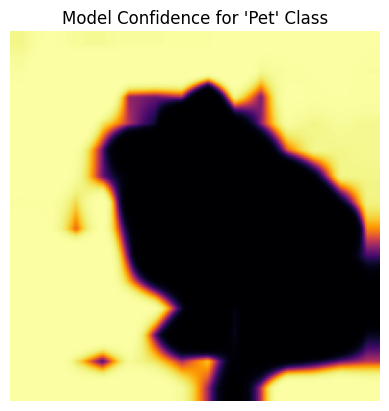

In [8]:
with torch.no_grad():
    x, _ = next(iter(trainloader))
    out = model(x.to(DEVICE_CUDA))
    out = F.interpolate(out, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
    heatmap = torch.softmax(out, dim=1)[0,1].cpu().numpy()  # class 1 prob map
    plt.imshow(heatmap, cmap='inferno')
    plt.title("Model Confidence for 'Pet' Class")
    plt.axis("off")
    plt.show()
